# Statistical Inference on the Stock Market
##### Group 6: Kaylie Nguyen, Chi Pham, Rohan Shan, Max Xu

In [1]:
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(stringi)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Introduction

Over the past few years, there has been a high level of inflation. The ideal annual inflation rate according to central banks across the world is 2%. However, throughout 2022, the inflation rate in the United States has been consistently above 7% (above 8% since March)[2]. This is due to excess government stimulus, and supply chain issues businesses have been facing since the onset of the COVID-19 pandemic [1]. 

To combat this, the US Federal Reserve has increased its interest rate from 0% all the way to 4% as of November 2022 [3]. Despite this, the interest rate is still below the inflation rate, therefore the real interest rate is still negative. Because of this many companies' profits have been hurt by higher costs of production and interest costs. Nevertheless, some companies that produce raw materials (commodities) have seen their revenue increase at a much faster rate than their cost of production. This leads us to the question: Have the U.S. raw material industries outperformed the rest of the U.S. market during this inflationary cycle?

We will begin by dividing up the companies listed in the NYSE Arca, NYSE, and NASDAQ by raw material, and non-raw material industries respectively and taking a sample of both. Then, we will create a bootstrap distribution for each as well as a side-by-side boxplot. After that, we will do a hypothesis test to compare the mean of the yearly performance rate in both sets of samples to make our conclusion. 


## Methods and Results

First, we will read the dataset that has already been downloaded from the website at a specific time as the data on the website is time sensitive: the data is updated every 10 seconds. The version we're using was downloaded on Oct 30th, 2022 at 3:41pm [5].

Dataset Download Link: https://drive.google.com/file/d/1uuD1eR6Y-Soys26rkYw6DP6LJyTGDxyD/view

In [2]:
df <- read.csv("america_2022-10-30-2.csv")
head(df)

,Ticker,Description,Price,Market.Capitalization,Enterprise.Value..MRQ.,Free.Cash.Flow..Annual.YoY.Growth.,EBITDA..Annual.YoY.Growth.,EPS.Diluted..Annual.YoY.Growth.,Gross.Profit..Annual.YoY.Growth.,Net.Income..Annual.YoY.Growth.,Yearly.Performance,Monthly.Performance,Change..,Gross.Margin..TTM.,Operating.Margin..TTM.,Pretax.Margin..TTM.,Net.Margin..TTM.,Industry
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAPL,Apple Inc.,155.74,2.477530e+12,2.50888e+12,19.891773,8.573353,8.892056,11.74200,5.410858,3.951408,5.4863181,12.6917511,43.30963,30.288744,30.204043,25.309641,Telecommunications Equipment
2,MSFT,Microsoft Corporation,235.87,1.758287e+12,1.71313e+12,16.092876,21.068848,19.786428,17.05911,18.715216,-27.273568,-0.3969427,1.2752254,68.26000,41.690508,41.740244,34.366121,Packaged Software
3,GOOG,Alphabet Inc.,96.58,1.248046e+12,1.25745e+12,56.412950,66.239223,91.418432,50.12498,88.812734,-34.432685,-1.4690879,0.4472179,55.86563,27.465095,28.003549,23.872310,Internet Software/Services
4,AMZN,"Amazon.com, Inc.",103.41,1.054953e+12,1.25309e+12,-156.804505,22.212676,54.889303,29.27591,56.410857,-39.208047,-9.5908376,-8.4867257,43.04438,2.688021,1.983309,2.254720,Internet Retail
5,TSLA,"Tesla, Inc.",228.52,7.216096e+11,9.05545e+11,83.806713,117.956441,667.843691,105.21870,700.579710,-35.827251,-19.2737036,-13.8473139,26.61261,16.710525,16.524852,14.936618,Motor Vehicles
6,BRK.A,Berkshire Hathaway Inc.,451900.00,6.671907e+11,6.29393e+11,-2.301857,12.738163,122.963852,13.07806,111.178006,3.956099,11.8196929,11.1767166,19.72554,13.559755,4.411983,4.041525,Multi-Line Insurance


In [3]:
# Selects only the Industry column so we can manually look up the names of the raw material industries
# After picking the raw material industry names, we display only the first few rows of the names 
# for better readability
head(unique(df["Industry"]))

,Industry
,<chr>
1,Telecommunications Equipment
2,Packaged Software
3,Internet Software/Services
4,Internet Retail
5,Motor Vehicles
6,Multi-Line Insurance


In [4]:
# Names of the Raw Material Industries
raw_material_industries <- c("Agricultural Commodities/Milling", "Aluminum", "Chemicals: Agricultural", "Chemicals: Major Diversified", "Chemicals: Specialty",
                 "Coal", "Food Distributors", "Food: Major Diversified", "Food: Meat/Fish/Dairy", "Forest Products", "Gas Distributors",
                 "Integrated Oil", "Oil & Gas Pipelines", "Oil & Gas Production", "Oil Refining/Marketing", "Other Metals/Minerals", "Precious Metals",
                 "Steel", "Textiles", "Tobacco", "Water Utilities")

# Add new column to identify whether an industry does raw material and select necessary columns only
df <- df %>%
    select(Ticker, Yearly.Performance, Industry) %>%
    mutate(Raw_material = if_else(Industry %in% raw_material_industries, 
                                  TRUE, 
                                  FALSE))

colnames(df) <- tolower(colnames(df))
head(df)

,ticker,yearly.performance,industry,raw_material
,<chr>,<dbl>,<chr>,<lgl>
1,AAPL,3.951408,Telecommunications Equipment,FALSE
2,MSFT,-27.273568,Packaged Software,FALSE
3,GOOG,-34.432685,Internet Software/Services,FALSE
4,AMZN,-39.208047,Internet Retail,FALSE
5,TSLA,-35.827251,Motor Vehicles,FALSE
6,BRK.A,3.956099,Multi-Line Insurance,FALSE


We separated the original dataset into 2 subsets: `rmc` including the raw material industries and `nrmc` including the rest of the market. Since these 2 smaller subsets contains data of large public companies that make up a major share of the market, we consider this as having access to the whole population in our problem and take 2 samples each of 10% of the size of the respective population: the raw market industries and the rest of the market.

In [5]:
set.seed(9284)

# Dataset of raw materials industries
rmc <- df %>%
        filter(raw_material) %>%
        select(-raw_material)

# Dataset of the rest of the market
nrmc <- df %>%
        filter(!raw_material) %>%
        select(-raw_material)

#10% of the population size of raw material industries
rmc_sample_size<-ceiling(nrow(rmc)*0.1)
rmc_sample_size

#10% of the population size of the rest of the market 
nrmc_sample_size<-ceiling(nrow(nrmc)*0.1)
nrmc_sample_size

#Single random sample of raw material industries
rmc_sample <- rmc |> 
    rep_sample_n(size = rmc_sample_size, replace = FALSE) %>% 
    ungroup() |>
    select(yearly.performance)

#Single random sample of the rest of the market
nrmc_sample <- nrmc |> 
    rep_sample_n(size = nrmc_sample_size, replace = FALSE) %>% 
    ungroup() |>
    select(yearly.performance)

head(rmc_sample)
head(nrmc_sample)

[1] 38

[1] 509

yearly.performance
<dbl>
38.805970
-20.348837
-68.410796
29.527559
6.199347
-22.141561


yearly.performance
<dbl>
1.944729
-92.398580
-6.966473
1.938776
26.618695
1.848049


Visualizing the two samples distribution (`rmc_sample` & `nrmc_sample`).

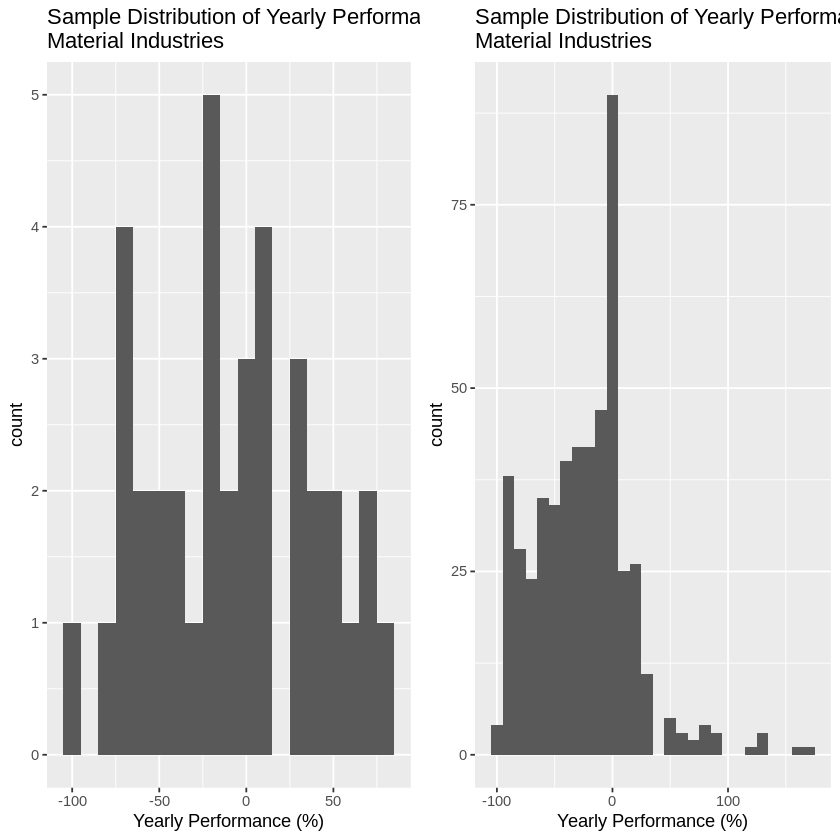

In [6]:
#Plotting Sample distribution of sample
rmc_sample_dist <- rmc_sample |>
    ggplot(aes(x = yearly.performance)) +
    geom_histogram(binwidth=10) +
    xlab("Yearly Performance (%)") +
    ggtitle("Sample Distribution of Yearly Performance for Raw Material Industries")

#Plotting Sample distribution of sample
nrmc_sample_dist <- nrmc_sample |>
    ggplot(aes(x = yearly.performance)) +
    geom_histogram(binwidth=10) +
    xlab("Yearly Performance (%)") +
    ggtitle("Sample Distribution of Yearly Performance for Non-Raw Material Industries")

#Side-by-side plot
plot_grid(rmc_sample_dist +
              labs(title = "Sample Distribution of Yearly Performance for Raw \nMaterial Industries",
                   xlab = "Yearly Performance (%)"),
          nrmc_sample_dist +
              labs(title = "Sample Distribution of Yearly Performance for Non-Raw \nMaterial Industries",
                   xlab = "Yearly Performance (%)"))

In [7]:
# Mean yearly performance for a single sample of raw material industries and rest of the market
sample_dfboth <- rbind(cbind(data = "Raw Material Industries", rmc_sample),
  cbind(data = "Rest of the market", nrmc_sample))

sample_summary <- sample_dfboth %>%
    group_by(data)%>%
    summarize(f_mean = mean(yearly.performance))

sample_summary

data,f_mean
<chr>,<dbl>
Raw Material Industries,-9.152618
Rest of the market,-24.401879


From the summary above, the mean yearly performance of the raw material industries sample appears to be higher than the sample mean for the rest of the market. These preliminary results support our suspect that the raw material industries might be performing better, and we'll proceed with the hypothesis test to see if there is concrete evidence supporting our suspicion.

## Hypothesis Testing
We perform the hypothesis test at significance level 0.05 where the null hypothesis is that there is no difference between the mean yearly performance of the raw material industries and the rest of the market; while the alternative hypothesis is that the mean yearly performance of the raw material industries is higher than that of the rest of the market. 

### Setting the hypothesis
$m_1$ is the mean of yearly performance of the Raw Material Industries  
$m_2$ is the mean of yearly performance of Other Industries   
$H_0: m_1 - m_2 = 0$  
$H_A: m_1 - m_2 > 0$  
$\alpha$ = 0.05

In [8]:
# Calculate the observed difference in means
head(sample_summary)

obs_means_diff <- sample_summary$f_mean[1] - sample_summary$f_mean[2]
obs_means_diff

data,f_mean
<chr>,<dbl>
Raw Material Industries,-9.152618
Rest of the market,-24.401879


[1] 15.24926

### Resampling method

In [9]:
set.seed(9284)

# Simulate null distribution with infer package
null_model <- sample_dfboth %>%
    specify(formula = yearly.performance ~ data) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 5000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("Raw Material Industries", "Rest of the market"))

head(null_model)

replicate,stat
<int>,<dbl>
1,5.8538595
2,-2.3100384
3,-0.6913932
4,4.1817407
5,-10.9150283
6,-0.9795403


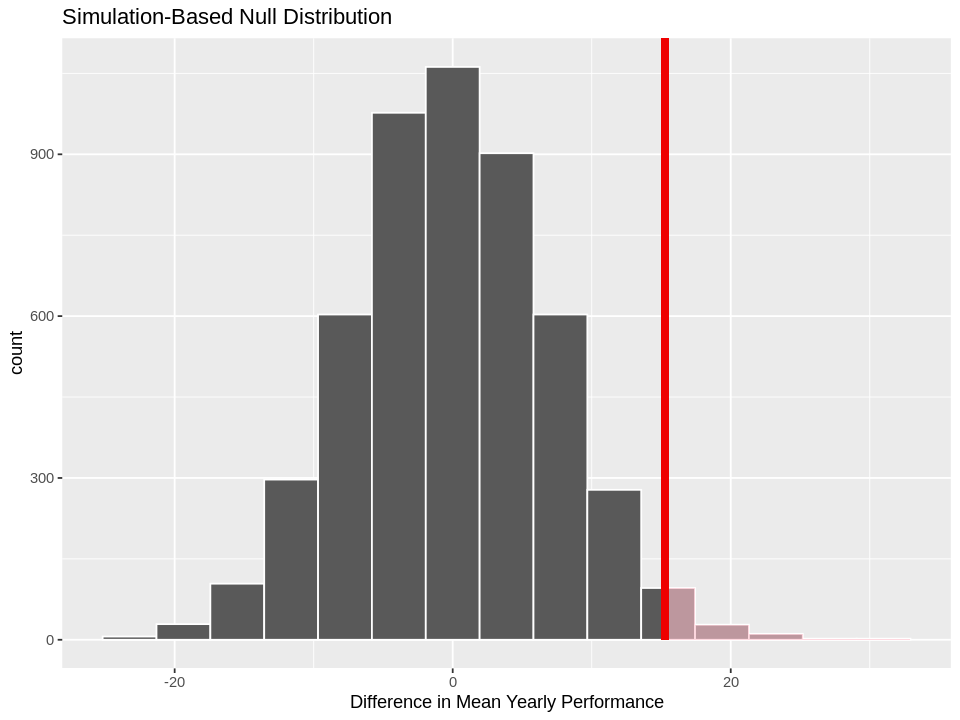

In [10]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Visualize
result_plot <- null_model %>%
    visualize() +
    shade_p_value(obs_stat = obs_means_diff, direction = "right") +
    labs(x = "Difference in Mean Yearly Performance")

result_plot

In [11]:
# Get p-value from null model
p_value_resampling <- null_model %>%
    get_p_value(obs_stat = obs_means_diff, direction = "right")

p_value_resampling

p_value
<dbl>
0.015


### Asymptotics method

**Two-sample t-test**  
Assumptions for t-test
1) Random, representative sample following a roughly normal distribution
2) Large enough sample size
3) Standard deviations of samples are approximately equal

In [12]:
# Obtain summary data frame for sample_var, and n
yearly_performance_summary <- sample_dfboth %>%
    group_by(data) %>%
    summarise(sample_var = var(yearly.performance), 
              n = sum(!is.na(yearly.performance)))

yearly_performance_summary

data,sample_var,n
<chr>,<dbl>,<int>
Raw Material Industries,2277.972,38
Rest of the market,1770.137,509


In [13]:
# Calculate test statistic
se <- sqrt(yearly_performance_summary$sample_var[1]/yearly_performance_summary$n[1] + yearly_performance_summary$sample_var[2]/yearly_performance_summary$n[2])
test_statistic = obs_means_diff / se

test_statistic

[1] 1.914789

$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
,$$

Using the formula above, we calculated the degree of freedom for our t-distribution to be around 41.

In [14]:
# Calculate p-value
p_value_asymptotics <- pt(test_statistic, df = 41, lower.tail = FALSE)

p_value_asymptotics

[1] 0.0312572

**95% Confidence Interval**

In [15]:
# Performing the hypothesis test using t.test
alternative_method <- 
    tidy(t.test(x = filter(sample_dfboth, data == "Raw Material Industries")$yearly.performance, 
                y = filter(sample_dfboth, data == "Rest of the market")$yearly.performance,
                alternative = "greater"))

alternative_method

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15.24926,-9.152618,-24.40188,1.914789,0.03122261,41.40733,1.849971,Inf,Welch Two Sample t-test,greater


The 95% confidence interval obtained is [1.84997, $\infty$]

### Results

From both methods of hypothesis testing, we got 2 different p-values: 0.015 for the resampling method and 0.031 for the asymptotics method. The p-value for two cases are slightly different; however, given our significance level 0.05, we'll reject the null hypothesis in favor of the alternative hypothesis in both methods. We claim that the raw material industries indeed perform better than the rest of the market.

Our 95% confidence interval is [1.84997, $\infty$] as corresponds to our one-sided hypothesis test. This confidence interval does not include 0, which agrees with our rejection of the null hypothesis. We are 95% confident that the actual difference in means between yearly performance of the raw material industries and the rest of the industries lies within [1.84997, $\infty$].

For our project, even though both methods for hypothesis testing yields the same conclusion, the bootstrap/resampling method seems to be slightly more trustworthy if we have to choose one. This is because there are assumptions we need to make in order for the asymptotic method to work. For example, the population distribution has to be approximately normal. In our case, from the non-raw material industries sample, the distribution looks skewed yet we still proceed with the method since our sample size is relative large. We also need to make assumption about the variance being equal but from our calculation, the variances of the two samples are quite different (2277.972 versus 1770.137). On the other hand, for the resampling method, since we've take 2 samples each of size of 10% of the population, which we believe will be good representatives of the population, the method will be relatively trustworthy.

## Discussion

### Summary and Implications

To conclude, using two sampling methods, asymptotic and bootstrapping, we have found that observed mean difference falls in the rejection zone. Therefore, we can say with a greater degree of confidence, that the commodity industry out-performs the rest of the market during inflationary times. This is because commodities are generally used as input goods, i.e, goods that are used as a mean of production. When there is excess supply of money in the economic system, the consumption increases, hence the demand for input goods increases proportionally. However, even when the inflationary pressure catches up with the economy, the demand for these input goods does not decrease by a considerable amount. 

Since the COVID pandemic, the United States has given stimulus of upwards of 13 trillion USD. For context, World War II costed the US 4 trillion dollars in today's terms. This level of quantitative easing caused demand to rip through the economy, however, the supply could not keep up with the demand for too long. Producers could not buy enough commodities for production, and the annual inflation rate increased to above 9.1% in June 2022. Since commodities are a necessity for production (and therefore consumption), investors flocked to commodity stocks as a safe haven. US oil and gas producer, Exxon Mobil Corp, has seen its market capitalization increase by above 70% year-to-date, whereas a tech giant like Amazon has seen it drop by above 45% [4]. 

### Evaluation

Our analysis overall used a very robust method. We first separated our data set into two populations - raw materials industries and non-raw materials industries. We sampled to obtain 10% of the two populations. However, we found that the variances of the two samples were too different for it to be considered a good comparison. Furthermore, we did not even get a roughly normal distribution for the sample of non-commodity companies, but we had a big sample size. However, we countered this problem by resampling when carrying out the hypothesis test. Again, we were able to reject the null hypothesis, reaffirming the conclusion from the asymptotic method.

Nonetheless, there are still flaws in the dataset. The dataset only contains companies in the NYSE, NASDAQ, and ETFs from NYSE Arca. It does not contain the OTC market (penny stocks), private companies, and most companies outside the United States. Although we can be confident about our conclusion given our robust methodology, we cannot make this conclusion with 100% surety, because of said concerns.

### Further Questions

This analysis and conclusion lead to many different further questions. First of all, through a simple eye-scan we noticed that some commodity industries were not performing like other commodities. We could then narrow the question even further to determine which commodities perform the best during high levels of inflation. Furthermore, we could also question the financial impact the rise in commodity prices have had on the rest of the industry. We can also question whether these patterns persisted during previous inflationary cycles. In addition, we could make use of this result in further research on predicting/forecasting future trends.

## References

[1] de Soyres, F., Santacreu, A.M., & Young,H. (2022, July 15). Fiscal policy and excess inflation during Covid-19: a cross-country view. FEDS Notes. Washington: Board of Governors of the Federal Reserve System. https://doi.org/10.17016/2380-7172.3083

[2] RateInflation. (n.d.). USA Inflation Rate | Inflation Rate and Consumer Price Index. Retrieved Novemer 2, 2022 from https://www.rateinflation.com/inflation-rate/usa-inflation-rate/ 

[3] Schneider, H., & Saphir, A. (2022, November 2). Fed Jacks up interest rates again, hints at smaller increases ahead. Reuters. Retrieved November 3, 2022 from https://www.reuters.com/markets/us/fed-set-another-big-rate-hike-may-tamp-down-future-tightening-2022-11-02/ 

[4] Surz, Ron. “Money Printing and Inflation: COVID, Cryptocurrencies and More.” Nasdaq.com, 16 Nov. 2021, www.nasdaq.com/articles/money-printing-and-inflation%3A-covid-cryptocurrencies-and-more. Accessed 26 Nov. 2022.

[5] TradingView Inc. (n.d.). Stock Screener. Retrieved October 28, 2022 from https://www.tradingview.com/screener/ 